In [19]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder

# Local imports
from src.collaborative_filtering import *
#from src.database import * <--- database approach instead of memory usage

# Collaborative Filtering

### We read x amount of playlist slices into memory
Each contains 1000 playlists. For example, 20 slices will take about 5GB of memory

In [20]:
folder = "data/playlist_data/"
co_occurences = update_co_occurrences_from_folder(folder, slice_limit=5)

Processing slice 1/5: mpd.slice.0-999.json
Processing slice 2/5: mpd.slice.1000-1999.json
Processing slice 3/5: mpd.slice.10000-10999.json
Processing slice 4/5: mpd.slice.100000-100999.json
Processing slice 5/5: mpd.slice.101000-101999.json


### We create a playlists for testing recommendations

In [21]:
# "90s Playlist"

playlist_1 = [
    ("Smash Mouth" ,"All Star"),
    ("Rick Astley", "Never Gonna Give You Up"),
    ("The Proclaimers", "I'm Gonna Be (500 Miles)"),
    ("Backstreet Boys", "I Want It That Way"),
    ("The Killers", "Mr. Brightside"),
]


In [22]:
get_recommendations(playlist_1, co_occurences, top_n=10)

Journey - Don't Stop Believin' - 0.14326923700397048
Dexys Midnight Runners - Come On Eileen - 0.12021304008227918
Queen - Bohemian Rhapsody - Remastered 2011 - 0.10991054384754884
OutKast - Hey Ya! - Radio Mix / Club Mix - 0.08831940256565037
Rick Springfield - Jessie's Girl - 0.08788703101660567
Vanessa Carlton - A Thousand Miles - 0.08568211967649743
R. Kelly - Ignition - Remix - 0.08495819790551361
Spice Girls - Wannabe - Radio Edit - 0.08369803941053391
Lynyrd Skynyrd - Sweet Home Alabama - 0.08208312930294659
blink-182 - All The Small Things - 0.07680166121528385


In [23]:
#"Pop Playlist"

playlist_2 = [
    ("Drake", "One Dance"),
    ("The Chainsmokers", "Closer"),
    ("Ed Sheeran", "Shape of You"),
    ("Justin Bieber", "Sorry"),
    ("The Weeknd", "Starboy"),
]


In [24]:
get_recommendations(playlist_2, co_occurences, top_n=10)

Major Lazer - Cold Water (feat. Justin Bieber & MØ) - 0.13594257771317855
The Chainsmokers - Don't Let Me Down - 0.13133278571985335
DRAM - Broccoli (feat. Lil Yachty) - 0.10871439788185103
Mike Posner - I Took A Pill In Ibiza - Seeb Remix - 0.10678774664197961
DJ Snake - Let Me Love You - 0.10555517322945326
Calvin Harris - This Is What You Came For - 0.0995580318367021
The Chainsmokers - Roses - 0.09544866523600537
Drake - Fake Love - 0.08557515177933339
Justin Bieber - Love Yourself - 0.08513062033951231
Ariana Grande - Side To Side - 0.0817531755324166


___
# Content based filtering

In [25]:
song_data = pd.read_csv('data/song_data.csv')
# Remove key, mode, time_signature, and duration_ms
song_data = song_data.drop(['key', 'mode', 'time_signature', 'duration_ms'], axis=1)

## Implement KNN

#### Feature scaling

In [26]:
# Scale numerical features
numerical_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
X = song_data[numerical_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# Genre encoding
genres = song_data[['genre']]
encoder = OneHotEncoder()
genres_encoded = encoder.fit_transform(genres).toarray()

#### Combine genres and numerical features and fit

In [28]:
genre_weight = 20 # The higher the weight, the more important the genre is in the recommendation

X_combined = np.concatenate((X_scaled, genres_encoded * genre_weight), axis=1)

knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X_combined)

NearestNeighbors(metric='euclidean', n_neighbors=10)

## Song Query

In [29]:
# Define song and artist which we want to find similar songs for
song_name = 'Boten Anna - Radio edit'
artist_name = 'Basshunter'

song_name2 = 'Show Me How'
artist_name2 = 'Men I Trust'

# Find the song in the dataset
song_query = song_data[(song_data['track_name'].str.lower() == song_name.lower()) & (song_data['artist_name'].str.lower() == artist_name.lower())]
song_query2 = song_data[(song_data['track_name'].str.lower() == song_name2.lower()) & (song_data['artist_name'].str.lower() == artist_name2.lower())]

[0.0635, 0.464, 0.971, 0.000108, 0.073, -0.13865, 0.26, 0.7787722222222222, 0.265]
[0.674, 0.791, 0.267, 0.534, 0.102, -0.299925, 0.0415, 0.9221666666666667, 0.544]


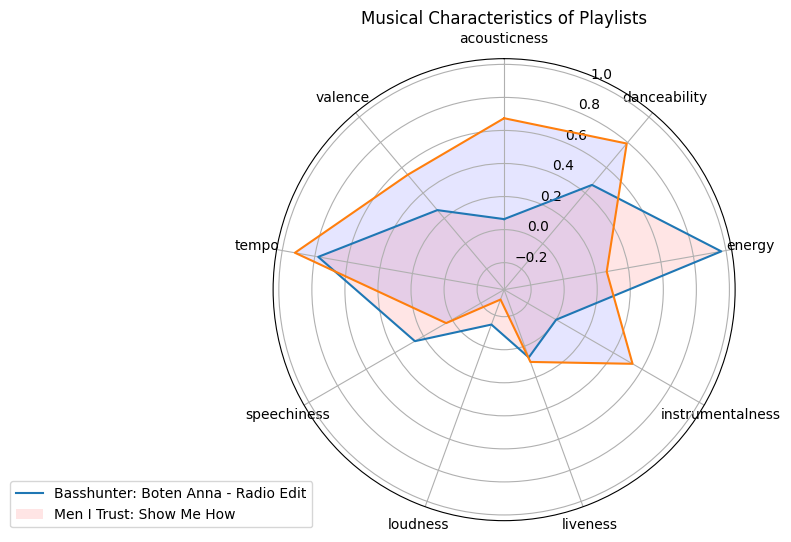

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
categories = numerical_features
N = len(categories)

# Values in a range from 0 to 1 for each category
# The values must be in the same order as the categories
values1 = song_query[numerical_features].values.tolist()[0]
values2 = song_query2[numerical_features].values.tolist()[0]

values1[7] /= 180
values2[7] /= 180
values1[5] /= 40
values2[5] /= 40

print(values1)
print(values2)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # This should complete the loop by adding the starting angle at the end.

# Your values lists must also complete the loop by having the first value at the end.
values1 += values1[:1]
values2 += values2[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)

# Draw one axe per variable + add labels
ax.plot(angles, values1)
ax.fill(angles, values1, 'red', alpha=0.1)

ax.plot(angles, values2)
ax.fill(angles, values2, 'blue', alpha=0.1)

# Add legend and title
plt.legend(['Basshunter: Boten Anna - Radio Edit', 'Men I Trust: Show Me How'], loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Musical Characteristics of Songs')

plt.show()

In [31]:
if not song_query.empty:
    # Scale numerical features of the query
    song_numerical_features = scaler.transform(song_query[numerical_features])
    
    # Encode genre of the query
    song_genre_encoded = encoder.transform(song_query[['genre']]).toarray()
    
    # Combine scaled numerical features and encoded genre for the query
    song_combined_features = np.hstack((song_numerical_features, song_genre_encoded * 20))
    
    # Use KNN to find the nearest neighbors
    distances, indices = knn.kneighbors(song_combined_features)
    
    print('Closest songs to |', song_name, '-', artist_name, '| are...')
    for i in range(1, 6):
        index = indices[0][i]
        print('----------')
        print(song_data.iloc[index][['track_name', 'artist_name']])
        
else:
    print("No song found. Check the song and artist names.")

Closest songs to | Boten Anna - Radio edit - Basshunter | are...
----------
track_name        Circles
artist_name    Digitalism
Name: 1122892, dtype: object
----------
track_name     I Can Walk On Water
artist_name             Basshunter
Name: 981839, dtype: object
----------
track_name     No Matter What
artist_name              T.I.
Name: 981916, dtype: object
----------
track_name     Barracuda
artist_name       Fergie
Name: 889963, dtype: object
----------
track_name       Sober
artist_name    Slushii
Name: 377949, dtype: object


In [32]:

playlist_numerical_features = []
playlist_genre_encoded = []
recommendations_idx = []

for artist_name, song_name in playlist_1:
    song_query = song_data[(song_data['track_name'].str.lower() == song_name.lower()) & (song_data['artist_name'].str.lower() == artist_name.lower())]

    if not song_query.empty:
        # Scale numerical features of the query
        song_numerical_features = scaler.transform(song_query[numerical_features])
        playlist_numerical_features.append(song_numerical_features)
        
        # Encode genre of the query
        song_genre_encoded = encoder.transform(song_query[['genre']]).toarray()
        playlist_genre_encoded.append(song_genre_encoded)
    else:
        print(f'No song found for {song_name} by {artist_name}. Check the song and artist names.')

# Aggregate features of the playlist
if playlist_numerical_features and playlist_genre_encoded:

    average_numerical_features = np.mean(np.vstack(playlist_numerical_features), axis=0)
    average_genre_encoded = np.mean(np.vstack(playlist_genre_encoded), axis=0)

    # Determine variance across the playlist for each numerical feature to use as a simple importance metric
    variances = np.var(np.vstack(playlist_numerical_features), axis=0)
    importance_weights = 1 / (variances + 1e-6)  
    normalized_importance_weights = importance_weights / importance_weights.max()

    # Apply weights to the aggregated playlist features
    weighted_playlist_features = average_numerical_features * normalized_importance_weights

    # Apply the same weighting to the full dataset numerical features before fitting KNN
    weighted_numerical_features = X_scaled * normalized_importance_weights

    knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
    knn.fit(X_combined)

    # Re-combine weighted numerical features with encoded categorical for the full dataset
    playlist_combined_features = np.hstack([weighted_playlist_features, average_genre_encoded])

    distances, indices = knn.kneighbors([playlist_combined_features])

    print('Closest songs to the playlist are...')
    for i in range(5):
        index = indices[0][i]
        recommendations_idx.append(index)
        print('----------')
        print(song_data.iloc[index][['track_name', 'artist_name']])
else:
    print('The playlist is empty or no songs were found.')


No song found for I'm Gonna Be (500 Miles) by The Proclaimers. Check the song and artist names.
Closest songs to the playlist are...
----------
track_name     In My Room (feat. Sizzy Rocket)
artist_name                  Young Rising Sons
Name: 532797, dtype: object
----------
track_name        The Great Exhale
artist_name    Great Lake Swimmers
Name: 2584, dtype: object
----------
track_name     What's She Crying For
artist_name      Justin Townes Earle
Name: 255429, dtype: object
----------
track_name     Would You Fight For My Love?
artist_name                      Jack White
Name: 110131, dtype: object
----------
track_name     Never Be Mine
artist_name      Angel Olsen
Name: 215019, dtype: object
